# **Import libaries**

In [2]:
import kagglehub

#for import the data
import pandas as pd
import numpy as np

# for the visualisation
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#for the text pre-processing (text cleaning)
import nltk
nltk.download('punkt')
import re #regular expression
import string
nltk.download('stopwords') #stopwords
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # word tokenization
from nltk.stem import WordNetLemmatizer # word lemmatization

#for feature extraction ( vectorazation)
from sklearn.feature_extraction.text import CountVectorizer

#for split the data into train and test
from sklearn.model_selection import train_test_split

#for the model training
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import joblib
#for the model evaluation
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

!pip install flask
!pip install flask_cors
import io
import re
import pickle
from flask_cors import CORS
from nltk.corpus import stopwords
from flask import Flask, render_template, request
from flask import Flask, request, render_template, jsonify

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# **Download data from Kagglehub**

In [3]:
# Download latest version
path = kagglehub.dataset_download("purusinghvi/email-spam-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Dell\.cache\kagglehub\datasets\purusinghvi\email-spam-classification-dataset\versions\1


# **Read data**

In [4]:
# Reading the data file
import pandas as pd
file_path = path.replace("\\", "/") + "/combined_data.csv"

data_raw = pd.read_csv(file_path)

data_raw.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


# **EDA**

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [6]:
data_raw.describe()

,label
count,83448.000000
mean,0.526196
std,0.499316
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
dataframe = pd.DataFrame(data_raw)

# Checking for null line
missing_values = dataframe.isnull().sum()
print(missing_values)

# Checking for noisy data
noisy_label = dataframe[~dataframe['label'].isin([0, 1])]
print(f"Noisy lines of data: {len(noisy_label)}")

# Removes null or outliers lines of data
dataframe = dataframe.dropna()
dataframe = dataframe.drop_duplicates()

label    0
text     0
dtype: int64
Noisy lines of data: 0


label
1    43910
0    39538
Name: count, dtype: int64


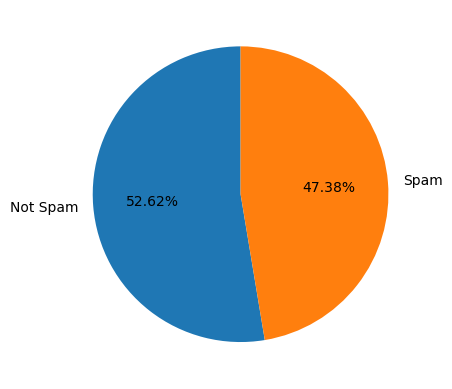

In [8]:
labels = {0 : "Not Spam", 1 : "Spam"}
label_counts = dataframe['label'].value_counts()
print(label_counts)

plt.pie(label_counts, labels=labels.values(), autopct="%.2f%%", startangle=90)
plt.show()

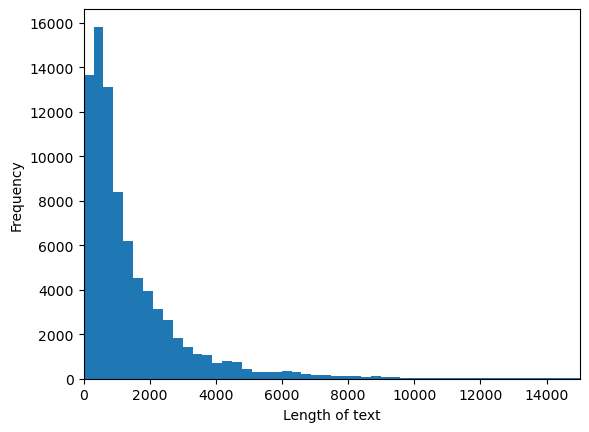

In [9]:
dataframe['length'] = dataframe['text'].apply(len)

plt.hist(dataframe['length'], bins=2000)
plt.xlim(0, 15000)
plt.xlabel('Length of text')
plt.ylabel('Frequency')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_13392\3844086248.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = dataframe.groupby('length_bins')['label'].value_counts().unstack(fill_value=0)


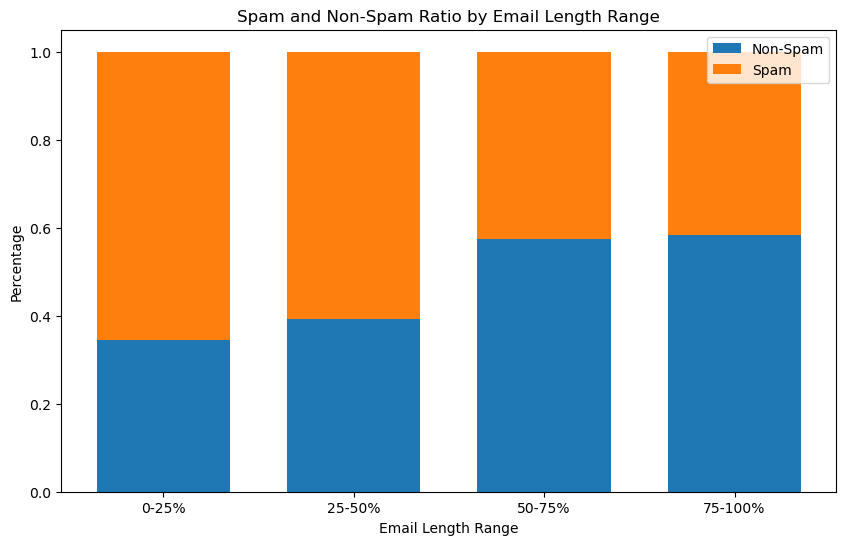

In [10]:
# 1. Calculate percentile values
bins = [
    0,
    dataframe['length'].describe()['25%'],
    dataframe['length'].describe()['50%'],
    dataframe['length'].describe()['75%'],
    dataframe['length'].max()
]

# 2. Create labels for the bins
labels = ['0-25%', '25-50%', '50-75%', '75-100%']

# 3. Categorize data into bins
dataframe['length_bins'] = pd.cut(dataframe['length'], bins=bins, labels=labels)

# 4. Compute the spam and non-spam ratio in each bin
grouped = dataframe.groupby('length_bins')['label'].value_counts().unstack(fill_value=0)

# Compute the total number of emails in each bin
grouped['total'] = grouped[0] + grouped[1]

# Compute the percentage ratio
grouped[0] = grouped[0] / grouped['total']
grouped[1] = grouped[1] / grouped['total']

# 5. Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bar for label 0 (non-spam)
ax.bar(grouped.index, grouped[0], label='Non-Spam', width=0.7)

# Plot stacked bar for label 1 (spam)
ax.bar(grouped.index, grouped[1], bottom=grouped[0], label='Spam', width=0.7)

ax.set_xlabel('Email Length Range')
ax.set_ylabel('Percentage')
ax.set_title('Spam and Non-Spam Ratio by Email Length Range')
ax.legend()
plt.show()

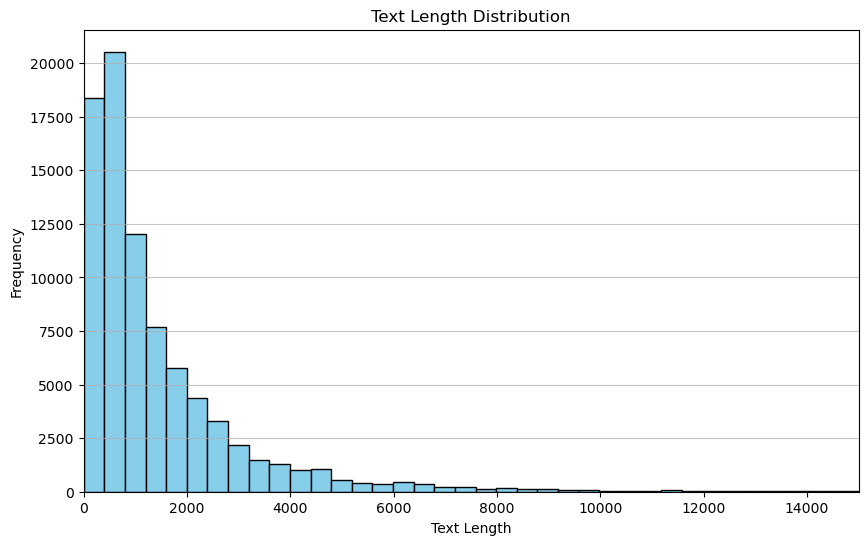

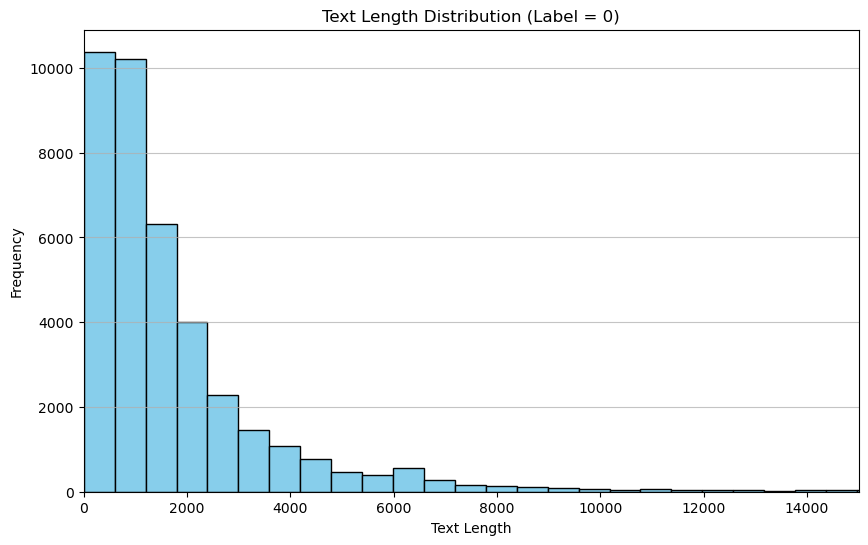

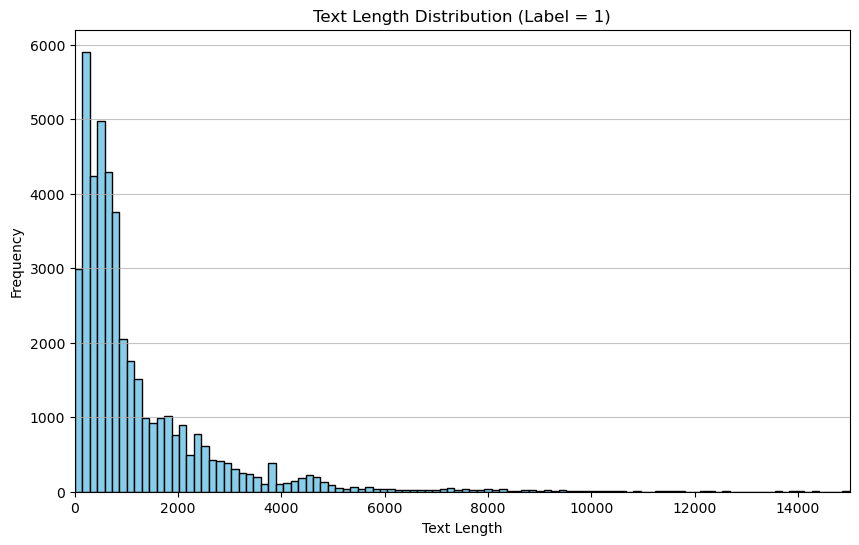

In [11]:
def plot_length_histogram(dataframe, label_filter=None, bins=100, xlim=None):
    """
    Plot a histogram of text length in the DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame containing 'text' and 'label' columns.
        label_filter (int, optional): Filter data by a specific label (e.g., 0 for non-spam, 1 for spam).
                                      If None, the histogram is plotted for the entire dataset.
        bins (int, optional): Number of bins in the histogram. Default is 100.
        xlim (tuple, optional): X-axis limits (e.g., (0, 15000)).
                                If None, no limit is applied.
    """

    # 1. Calculate text length
    dataframe['length'] = dataframe['text'].apply(len)

    # 2. Filter data if needed
    if label_filter is not None:
        data_to_plot = dataframe[dataframe['label'] == label_filter]
        title = f"Text Length Distribution (Label = {label_filter})"
    else:
        data_to_plot = dataframe
        title = "Text Length Distribution"

    # 3. Plot histogram
    plt.figure(figsize=(10, 6))  # Increase figure size for better visibility
    plt.hist(data_to_plot['length'], bins=bins, color='skyblue', edgecolor='black')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.title(title)

    # 4. Apply x-axis limit if specified
    if xlim is not None:
        plt.xlim(xlim)

    plt.grid(axis='y', alpha=0.75)  # Add vertical grid for better readability
    plt.show()

# --- Usage ---

# Plot histogram for the entire dataset
plot_length_histogram(dataframe, bins=1500, xlim=(0, 15000))

# Plot histogram for non-spam emails (label = 0)
plot_length_histogram(dataframe, label_filter=0, bins=1000, xlim=(0, 15000))

# Plot histogram for spam emails (label = 1)
plot_length_histogram(dataframe, label_filter=1, bins=1000, xlim=(0, 15000))


# **Text Pre-Processing**

### **Text Cleaning**

In [ ]:
#Clean Text
def clean_text(data):
  # Convert characters to lowercase
  data['clean_text']=data['text'].str.lower()
  # Remove URLS
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"http\S+", "", elem))
  # Remove punctuation
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
  # Remove
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\n',"",elem))
  # Remove digits
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\d+',"",elem))
  # Remove multiple spaces
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+'," ",elem))
  # Remove single characters
  data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))
  return data

In [13]:
data = clean_text(data_raw)
data.head()

,label,text,clean_text
0,1,ounce feather bowl hummingbird opec moment ala...,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...,university degree obtain prosperous future mon...
4,0,thanks for all your answers guys i know i shou...,thanks for all your answers guys know should h...


### **Remove StopWords**

In [14]:
def remove_stop_words(text):
  stopW=stopwords.words('english')
  s=""
  for i in text.split():
    if i not in stopW:
        s=s+i+" "
  return s

In [15]:
data['clean_text']=data['clean_text'].apply(lambda x:remove_stop_words(x))

### **Lemmatization**

In [16]:
def lemmatize_text(text):
    lem = WordNetLemmatizer()
    return " ".join([lem.lemmatize(word) for word in text.split()])

data['clean_text'] = data['clean_text'].apply(lemmatize_text)

In [17]:
print('text before cleaning :',data['text'][5])
print('text after cleaning :',data['clean_text'][5])

text before cleaning : larry king live at escapenumber escapenumber p m et on friday june escapenumber escapenumber cnn tonight michael moore taking your calls michael moore in his first primetime interview on his controversial new film sicko that has everyone talking he says that americas health care industry gets away with murder what do you think michael moore for the hour answering your calls and emails tonight only on larry king live visit http www cnn com larryking and e mail us your questions for tonights guest larry king live the greatest interviews  now available on dvd larry king live is the first worldwide phone in television talk show and cnn's highest rated program this commemorative dvd celebrates larry kings escapenumber years in broadcasting the dvd is hosted by larry king in his warm engaging style and contains over escapenumber hours of his most extraordinary and entertaining programming this dvd can be purchased at http whv warnerbros com sites kingoftalk larry

# **Feature Extraction (Word Vector Using Bag Of Word BOW)**

In [18]:
"""
 CountVectorizer creates a dictionary containing the occurrence number of tokens
"""
#convert text to vector (using Count Vectorizer)
count_vect = CountVectorizer()
X = count_vect.fit_transform(data['clean_text'])

In [19]:
print(X.shape)

(83448, 405232)


In [20]:
#divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=0)

# **Train model and Evaluating the Model**

In [21]:
def evaluate_model(y_true, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    return accuracy, precision, recall, f1

In [ ]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Plot Confusion Matrix for the model.

    Parameters:
    - y_true: Ground truth labels
    - y_pred: Predicted labels from the model
    - model_name: Model name to display on the chart (default is "Model")

    Returns:
    - cm: Confusion matrix
    """
    # Tính toán ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)  # False Positive Rate, True Positive Rate, Thresholds
    # Tính AUC
    roc_auc = auc(fpr, tpr)

    # Vẽ ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", label=f"{model_name} AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    return roc_auc

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Vẽ Confusion Matrix cho mô hình.

    Parameters:
    - y_true: Nhãn thực tế (ground truth)
    - y_pred: Nhãn dự đoán từ mô hình
    - model_name: Tên mô hình để hiển thị trên biểu đồ (mặc định là "Model")

    Returns:
    - cm: Ma trận nhầm lẫn (confusion matrix)
    """
    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix ({model_name}):")
    print(cm)

    # Draw to Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Spam', 'Spam'],
                yticklabels=['Not Spam', 'Spam'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return cm

## **Naive Bayes**

In [ ]:
# Training Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_prob = nb_model.predict_proba(X_test)[:, 1]

In [ ]:
# Model evaluation 
nb_metrics = evaluate_model(y_test, nb_pred, nb_prob, "Naive Bayes")


Naive Bayes Metrics:
Accuracy:  0.9761
Precision: 0.9863
Recall:    0.9679
F1-score:  0.9770


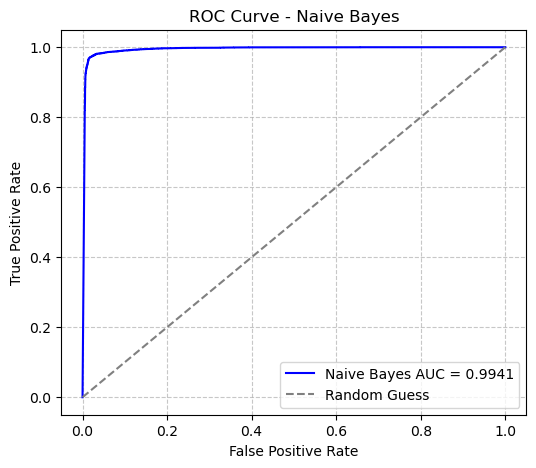

AUC for Naive Bayes: 0.9941


In [26]:
# Plot ROC Curve and Calculate AUC
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]
roc_auc_nb = plot_roc_curve(y_test, y_pred_proba, model_name="Naive Bayes")
print(f"AUC for Naive Bayes: {roc_auc_nb:.4f}")

Confusion Matrix (Navie Bayes):
[[7824  118]
 [ 281 8467]]


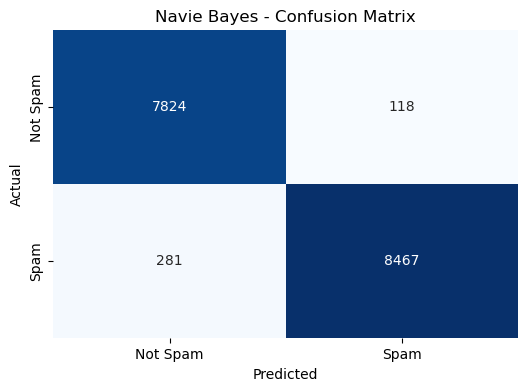

In [27]:
# Confusion matrix
nb_cm = plot_confusion_matrix(y_test, nb_pred, model_name="Navie Bayes")

## **Random Forest**

In [ ]:
# Training Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
# Model evaluation 
rf_metrics = evaluate_model(y_test, rf_pred, rf_prob, "Random Forest")


Random Forest Metrics:
Accuracy:  0.9775
Precision: 0.9867
Recall:    0.9701
F1-score:  0.9783


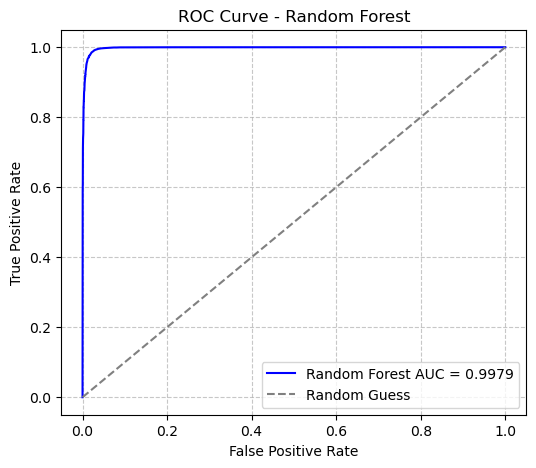

AUC for Random Forest: 0.9941


In [30]:
# Plot ROC Curve and Calculate AUC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = plot_roc_curve(y_test, y_pred_proba, model_name="Random Forest")
print(f"AUC for Random Forest: {roc_auc_nb:.4f}")

Confusion Matrix (Random Forest):
[[7828  114]
 [ 262 8486]]


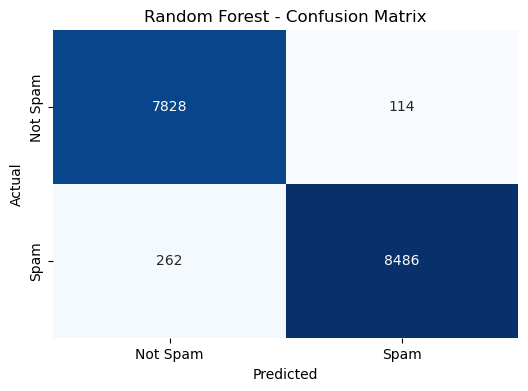

In [31]:
# Confusion matrix
rf_cm = plot_confusion_matrix(y_test, rf_pred, model_name="Random Forest")

## **Logistic Regression**

In [ ]:
# Training Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_prob = lr_model.predict_proba(X_test)[:, 1]

In [ ]:
# Model evaluation
lr_metrics = evaluate_model(y_test, lr_pred, lr_prob, "Logistic Regression")


Logistic Regression Metrics:
Accuracy:  0.9844
Precision: 0.9794
Recall:    0.9911
F1-score:  0.9852


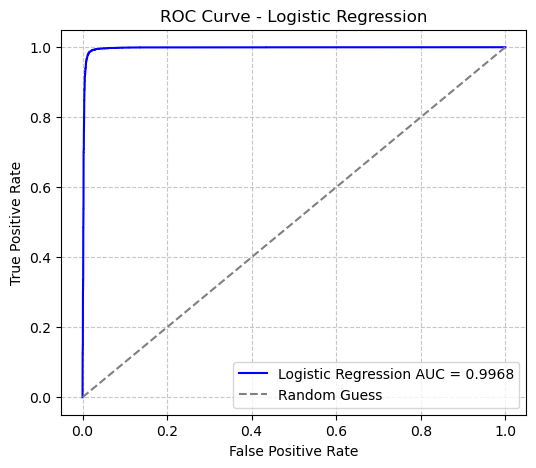

AUC for Logistic Regression: 0.9941


In [34]:
# Plot ROC Curve and Calculate AUC
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
roc_auc_lr = plot_roc_curve(y_test, y_pred_proba, model_name="Logistic Regression")
print(f"AUC for Logistic Regression: {roc_auc_nb:.4f}")

Confusion Matrix (Logistic Regression):
[[7760  182]
 [  78 8670]]


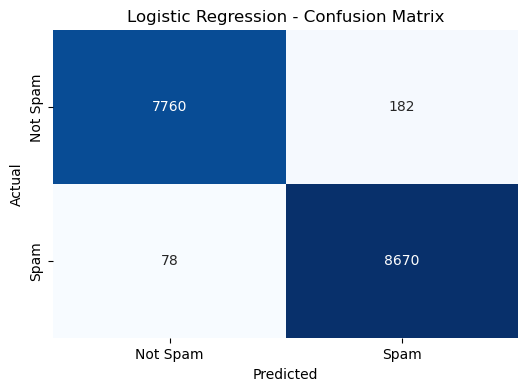

In [35]:
# Confusion matrix
lr_cm = plot_confusion_matrix(y_test, lr_pred, model_name="Logistic Regression")

## **Compare Models**

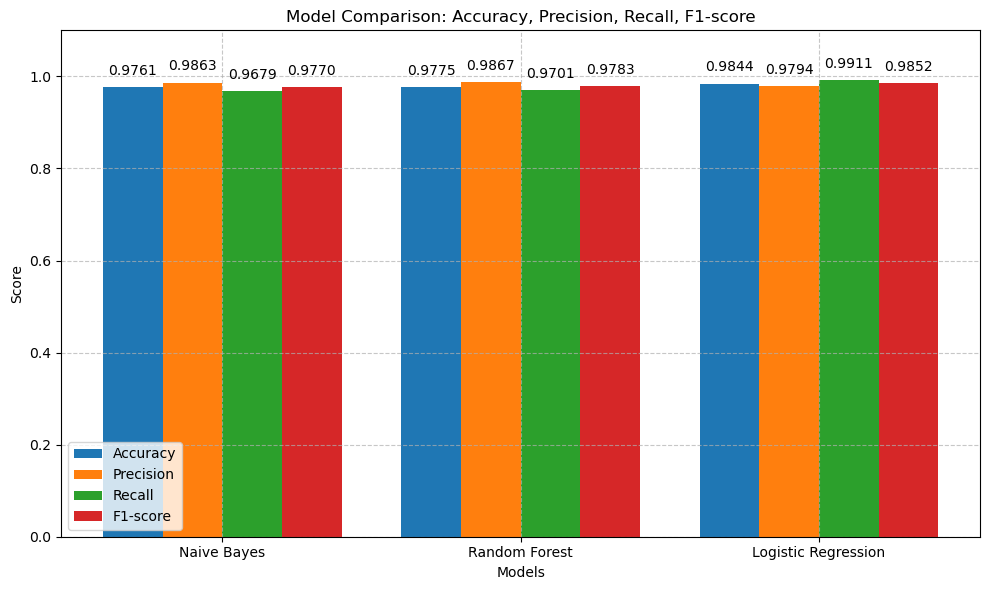

In [ ]:
# Function to draw comparison chart
def plot_model_comparison(models_metrics, metrics_names=['Accuracy', 'Precision', 'Recall', 'F1-score']):
    """
    Draw a bar chart comparing the metrics of different models.

    Parameters:
    - models_metrics: Dictionary containing model names and their metrics (accuracy, precision, recall, f1).
    - metrics_names: List of metric names to display.
    """
    model_names = list(models_metrics.keys())
    metrics_values = np.array([models_metrics[name] for name in model_names]).T

    bar_width = 0.2
    index = np.arange(len(model_names))

    plt.figure(figsize=(10, 6))
    for i, metric in enumerate(metrics_names):
        plt.bar(index + i * bar_width, metrics_values[i], bar_width, label=metric)

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Comparison: Accuracy, Precision, Recall, F1-score')
    plt.xticks(index + bar_width * 1.5, model_names)
    plt.legend()
    plt.ylim(0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)

    for i, metric_values in enumerate(metrics_values):
        for j, value in enumerate(metric_values):
            plt.text(index[j] + i * bar_width, value + 0.02, f'{value:.4f}',
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

models_metrics = {
    'Naive Bayes': nb_metrics,
    'Random Forest': rf_metrics,
    'Logistic Regression': lr_metrics
}

# Draw comparison chart
plot_model_comparison(models_metrics)

# **Save and Deployment**

## **Save models and vectorizer**

In [ ]:
# Save models và vectorizer
with open("naive_bayes.pkl", "wb") as f:
    pickle.dump(nb_model, f)
joblib.dump(rf_model, 'random_forest.pkl')
joblib.dump(lr_model, 'logistic_regression.pkl')
joblib.dump(count_vect, 'vectorizer.pkl')

['vectorizer.pkl']

In [ ]:
with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

print(type(vectorizer))  # It is <class 'sklearn.feature_extraction.text.CountVectorizer'>
print(vectorizer.get_feature_names_out()[:10])  

<class 'sklearn.feature_extraction.text.CountVectorizer'>
['__' '___' '____' '__buy' '__quem' '_a' '_address' '_agenda' '_amount'
 '_an']


## **Deployment with Flask**

In [39]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = clean_text(text)  # Chuyển thành chữ thường
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization và xóa stop words
    return ' '.join(tokens)

In [1]:
from flask import Flask, render_template, request
from flask_cors import CORS
import joblib
import pickle

app = Flask(__name__)
CORS(app)

# Load models and vectorizer
with open("naive_bayes.pkl", "rb") as f:
    nb_model = joblib.load(f)
with open("random_forest.pkl", "rb") as f:
    rf_model = joblib.load(f)
with open("logistic_regression.pkl", "rb") as f:
    lr_model = joblib.load(f)
with open("vectorizer.pkl", "rb") as f:
    count_vect = pickle.load(f)

# Prediction function
def predict_email(text, model):
    text_vector = count_vect.transform([text])
    pred = model.predict(text_vector)[0]
    return "Spam" if pred == 1 else "Not Spam"

@app.route("/", methods=["GET", "POST"])
def home():
    text, prediction, model_choice = "", None, ""
    
    if request.method == "POST":
        text = request.form.get("text", "")
        model_choice = request.form.get("model", "logistic_regression")
        
        # Select the model
        if model_choice == "naive_bayes":
            selected_model = nb_model
        elif model_choice == "random_forest":
            selected_model = rf_model
        else:
            selected_model = lr_model
        
        # Get prediction
        prediction = predict_email(text, selected_model)
    
    return render_template("home.html", text=text, prediction=prediction, model_choice=model_choice)

if __name__ == "__main__":
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [30/Mar/2025 21:49:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2025 21:49:20] "GET /static/Nhom19.jpg HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2025 21:49:34] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2025 21:49:34] "GET /static/Nhom19.jpg HTTP/1.1" 304 -
